In [3]:
import os
import json
import pickle

from tqdm import tqdm

import anndata
import numpy as np
import pandas as pd
import scanpy as sc
import scvi
import sparse
import torch
import umap
from datasets import Dataset, concatenate_datasets, load_from_disk
import matplotlib.pyplot as plt

from utils.combo_split import combo_split_nochron

# Create processed datasets

In [2]:
data_dir = "/home/dfl32/scratch/cinemaot_data/cell_sentences_hf/jeff_data_HF_dataset_dict"
train_file = "train_adata_all_genes.h5ad"
val_file = "val_adata_all_genes.h5ad"
test_file = "test_adata_all_genes.h5ad"
train_path = os.path.join(data_dir, train_file)
val_path = os.path.join(data_dir, val_file)
test_path = os.path.join(data_dir, test_file)

train_adata = sc.read_h5ad(train_path)
val_adata = sc.read_h5ad(val_path)
test_adata = sc.read_h5ad(test_path)

adata_preproc = anndata.concat([train_adata, val_adata, test_adata])
print(adata_preproc)

/home/dfl32/.conda/envs/c2s2/lib/python3.11/site-packages/anndata/_core/anndata.py:1818: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")
/home/dfl32/.conda/envs/c2s2/lib/python3.11/site-packages/anndata/_core/anndata.py:1818: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")
/home/dfl32/.conda/envs/c2s2/lib/python3.11/site-packages/anndata/_core/anndata.py:1818: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


AnnData object with n_obs × n_vars = 96423 × 21710
    obs: 'perturbation', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'batch', 'cell_type0528'


/home/dfl32/.conda/envs/c2s2/lib/python3.11/site-packages/anndata/_core/anndata.py:1818: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


In [8]:
import pandas as pd
from datasets import Dataset
from scipy.sparse import issparse

# Assuming 'adata_preproc' is your AnnData object
# Convert the expression matrix to a dense format if it's sparse
if issparse(adata.X):
    expression_data = adata.X.toarray()
else:
    expression_data = adata.X

# Convert to DataFrame
df = pd.DataFrame(expression_data)

# Convert each row into a single column of lists (assuming each row is a cell's expression profile)
df['expr'] = df.apply(lambda row: row.tolist(), axis=1)

# Create a Hugging Face Dataset
hf_dataset = Dataset.from_pandas(df[['expr']])

# Save the dataset to disk
hf_dataset.save_to_disk("/home/dfl32/scratch/cinemaot_data/ifm_hf_ds/gaussian_768_hf_ds")


Saving the dataset (0/2 shards):   0%|          | 0/92125 [00:00<?, ? examples/s]

In [3]:
adata_preproc.obs_names_make_unique()

In [4]:
adata_preproc.obs

perturbation  n_genes  n_genes_by_counts  \
CTCGAGGGTAGCGTGA-1           IFN-III      906                906   
GATCAGTTCCTTTACA-1       IFNb + IFNg      914                914   
CCTCAGTCATGCTGGC-1              IFNb     1333               1333   
CCTACCATCACATACG-1    No stimulation     1380               1380   
GAGGTGAGTACCATCA-1              TNFa     2308               2308   
...                              ...      ...                ...   
AGAGCGACAAAGAATC-1-1  No stimulation      842                842   
AGAGCTTGTCCTCTTG-1       IFNb + IL-6     1536               1536   
GTAGTCACAGATCCAT-1              IFNb     1210               1210   
TTCGAAGCAGCTCGAC-1    No stimulation     1246               1246   
GGCGTGTCATTCCTGC-1       IFNb + IL-6      966                966   

                      total_counts  total_counts_mt  pct_counts_mt  \
CTCGAGGGTAGCGTGA-1          2192.0             98.0       4.470803   
GATCAGTTCCTTTACA-1          1769.0             46.0       2.600339   
CCTCAGTCATGCTGGC-1          3043.0             82.0       2.694709   
CCTACCATCACATACG-1          4104.0            176.0       4.288499   
GAGGTGAGTACCATCA-1          7757.0            322.0       4.151090   
...                            ...              ...            ...   
AGAGCGACAAAGAATC-1-1        1428.0             30.0       2.100840   
AGAGCTTGTCCTCTTG-1          3969.0            108.0       2.721088   
GTAGTCACAGATCCAT-1          2948.0             93.0       3.154681   
TTCGAAGCAGCTCGAC-1          3907.0            150.0       3.839263   
GGCGTGTCATTCCTGC-1          1882.0             37.0       1.965994   

                                batch cell_type0528  
CTCGAGGGTAGCGTGA-1    Donor 2 chronic         CD8 T  
GATCAGTTCCTTTACA-1    Donor 3 chronic         CD8 T  
CCTCAGTCATGCTGGC-1    Donor 3 chronic         CD4 T  
CCTACCATCACATACG-1    Donor 2 chronic         CD4 T  
GAGGTGAGTACCATCA-1    Donor 2 chronic         CD4 T  
...                               ...           ...  
AGAGCGACAAAGAATC-1-1    Donor 2 acute         CD8 T  
AGAGCTTGTCCTCTTG-1    Donor 3 chronic         CD4 T  
GTAGTCACAGATCCAT-1    Donor 3 chronic         CD4 T  
TTCGAAGCAGCTCGAC-1    Donor 2 chronic         CD4 T  
GGCGTGTCATTCCTGC-1    Donor 2 chronic         CD4 T  

[96423 rows x 8 columns]

In [4]:
adata = sc.read_h5ad("/home/dfl32/project/ifm/cinemaot_data/raw_cinemaot.h5ad")

/home/dfl32/.conda/envs/c2s2/lib/python3.11/site-packages/anndata/_core/anndata.py:1818: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


In [5]:
sc.pp.filter_cells(adata, min_genes=200)
sc.pp.filter_genes(adata, min_cells=3)
adata = adata[adata.obs.n_genes_by_counts < 2500, :]
adata = adata[adata.obs.pct_counts_mt < 5, :].copy()
sc.pp.normalize_total(adata, target_sum=1e4)
sc.pp.log1p(adata)

/home/dfl32/.conda/envs/c2s2/lib/python3.11/site-packages/anndata/_core/anndata.py:1818: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")
/home/dfl32/.conda/envs/c2s2/lib/python3.11/site-packages/anndata/_core/anndata.py:1818: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")
/home/dfl32/.conda/envs/c2s2/lib/python3.11/site-packages/anndata/_core/anndata.py:1818: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


# PCA plots

In [18]:
sc.tl.pca(adata, n_comps=1000)

# Get the explained variance ratio
explained_variance_ratio = adata.uns['pca']['variance_ratio']

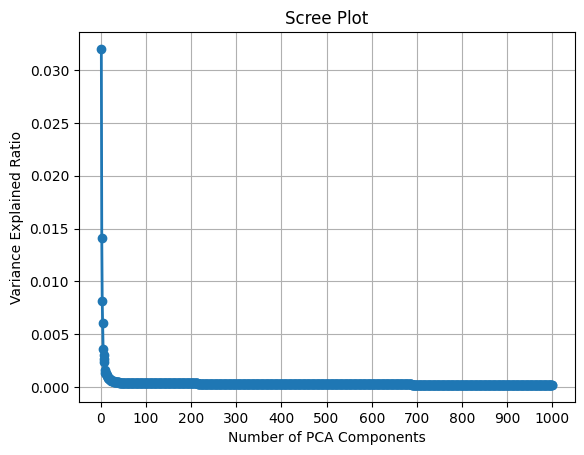

In [22]:
# Generate the cumulative scree plot
plt.plot(range(1, len(explained_variance_ratio) + 1), explained_variance_ratio, 'o-', linewidth=2, markersize=6)
plt.title('Scree Plot')
plt.xlabel('Number of PCA Components')
plt.ylabel('Variance Explained Ratio')
plt.xticks(range(0, len(explained_variance_ratio) + 1, 100))
plt.grid(True)
plt.show()

Total explained variance ratio: 0.3753059285298816


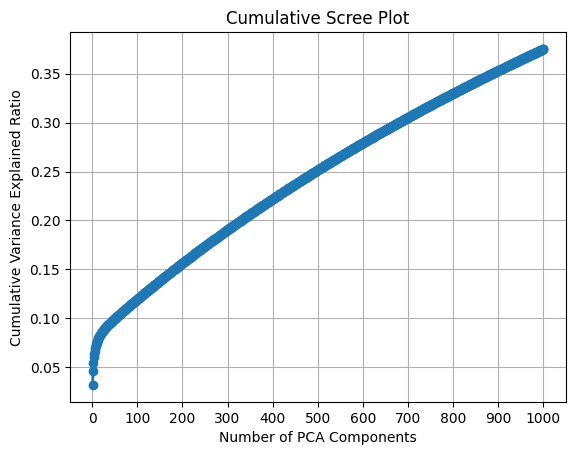

In [23]:
# Calculate the cumulative explained variance ratio
cumulative_explained_variance_ratio = explained_variance_ratio.cumsum()

# Print the total explained variance ratio
print(f"Total explained variance ratio: {cumulative_explained_variance_ratio[-1]}")


plt.plot(range(1, len(cumulative_explained_variance_ratio) + 1), cumulative_explained_variance_ratio, 'o-', linewidth=2, markersize=6)
plt.title('Cumulative Scree Plot')
plt.xlabel('Number of PCA Components')
plt.ylabel('Cumulative Variance Explained Ratio')
plt.xticks(range(0, len(cumulative_explained_variance_ratio) + 1, 100))
plt.grid(True)
plt.show()

# Back to analysis

In [42]:
path = "/home/dfl32/project/ifm/cinemaot_data/normalized_cinemaot.h5ad"

adata.write_h5ad(path)

In [5]:
sc.pp.highly_variable_genes(adata, n_top_genes=768, min_mean=0.0125, max_mean=3, min_disp=0.5)
adata = adata[:, adata.var.highly_variable].copy()

/home/dfl32/.conda/envs/c2s2/lib/python3.11/site-packages/scanpy/preprocessing/_highly_variable_genes.py:226: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  disp_grouped = df.groupby("mean_bin")["dispersions"]
/home/dfl32/.conda/envs/c2s2/lib/python3.11/site-packages/anndata/_core/anndata.py:1818: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


In [6]:
adata

AnnData object with n_obs × n_vars = 92125 × 768
    obs: 'perturbation', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'batch'
    var: 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'log1p', 'hvg'

In [7]:
path = "/home/dfl32/project/ifm/cinemaot_data/hvg_normalized_cinemaot_768.h5ad"
adata.write_h5ad(path)

In [7]:
import pandas as pd
from datasets import Dataset
from scipy.sparse import issparse
from sklearn.decomposition import TruncatedSVD, PCA
from sklearn.preprocessing import StandardScaler, MinMaxScaler


def run_pca(
    data,
    n_components=2,
    num_samples=2000,
    normalize=False,
    scale=False,
    minmax_scale=False,
    save_dir="/home/dfl32/project/ifm/scalers"
):
    pca = PCA(n_components=n_components, svd_solver='randomized')
    sample_indices = np.random.choice(data.shape[0], size=num_samples, replace=False)
    sampled_data = data[sample_indices, :]
    print(sampled_data.shape)
    pca.fit(sampled_data)
    print("fit_done")
    transformed_data = pca.transform(data)
    
    if normalize:
        first_component_std = np.std(transformed_data[:, 0])
        transformed_data = transformed_data/first_component_std

    if scale:
        scaler = StandardScaler()
        print("Scaling data...")
        transformed_data = scaler.fit_transform(transformed_data)

        save_name = f"pcadim{n_components}_numsamples{num_samples}.pickle"
        save_path = os.path.join(save_dir, save_name)
        print(f"Saving scaler to {save_path}")
        with open(save_path, 'wb') as f:
            pickle.dump(scaler, f)

    if minmax_scale:
        scaler = MinMaxScaler(feature_range=(-1,1))
        print("Scaling data...")
        transformed_data = scaler.fit_transform(transformed_data)

        save_name = f"pcadim{n_components}_numsamples{num_samples}_minmax.pickle"
        save_path = os.path.join(save_dir, save_name)
        print(f"Saving scaler to {save_path}")
        with open(save_path, 'wb') as f:
            pickle.dump(scaler, f)
            
    return transformed_data

# Assuming 'adata_preproc' is your AnnData object
# Convert the expression matrix to a dense format if it's sparse
if issparse(adata.X):
    expression_data = adata.X.toarray()
else:
    expression_data = adata.X

dims = [768, 50, 20, 10]
normalize = False
scale = False
minmax_scale = True
for dim in tqdm(dims):
    transformed_data = run_pca(expression_data, n_components=dim, normalize=normalize, scale=scale, minmax_scale=minmax_scale)
    # Convert to DataFrame
    df = pd.DataFrame(transformed_data)
    
    # Convert each row into a single column of lists (assuming each row is a cell's expression profile)
    df['expr'] = df.apply(lambda row: row.tolist(), axis=1)
    
    # Create a Hugging Face Dataset
    hf_dataset = Dataset.from_pandas(df[['expr']])
    
    # Save the dataset to disk
    hf_dataset.save_to_disk(f"/home/dfl32/scratch/cinemaot_data/ifm_hf_ds/gaussian_pca{dim}_norm{normalize}_scale{scale}_minmax{minmax_scale}_hf_ds")

  0%|          | 0/4 [00:00<?, ?it/s]

(2000, 21710)
fit_done
Scaling data...
Saving scaler to /home/dfl32/project/ifm/scalers/pcadim768_numsamples2000_minmax.pickle


Saving the dataset (0/2 shards):   0%|          | 0/92125 [00:00<?, ? examples/s]

 25%|██▌       | 1/4 [10:53<32:39, 653.08s/it]

(2000, 21710)
fit_done
Scaling data...
Saving scaler to /home/dfl32/project/ifm/scalers/pcadim50_numsamples2000_minmax.pickle


Saving the dataset (0/1 shards):   0%|          | 0/92125 [00:00<?, ? examples/s]

 50%|█████     | 2/4 [11:27<09:38, 289.36s/it]

(2000, 21710)
fit_done
Scaling data...
Saving scaler to /home/dfl32/project/ifm/scalers/pcadim20_numsamples2000_minmax.pickle


Saving the dataset (0/1 shards):   0%|          | 0/92125 [00:00<?, ? examples/s]

 75%|███████▌  | 3/4 [11:47<02:46, 166.43s/it]

(2000, 21710)
fit_done
Scaling data...
Saving scaler to /home/dfl32/project/ifm/scalers/pcadim10_numsamples2000_minmax.pickle


Saving the dataset (0/1 shards):   0%|          | 0/92125 [00:00<?, ? examples/s]

100%|██████████| 4/4 [12:03<00:00, 180.98s/it]


In [8]:
transformed_data.shape

(92125, 768)

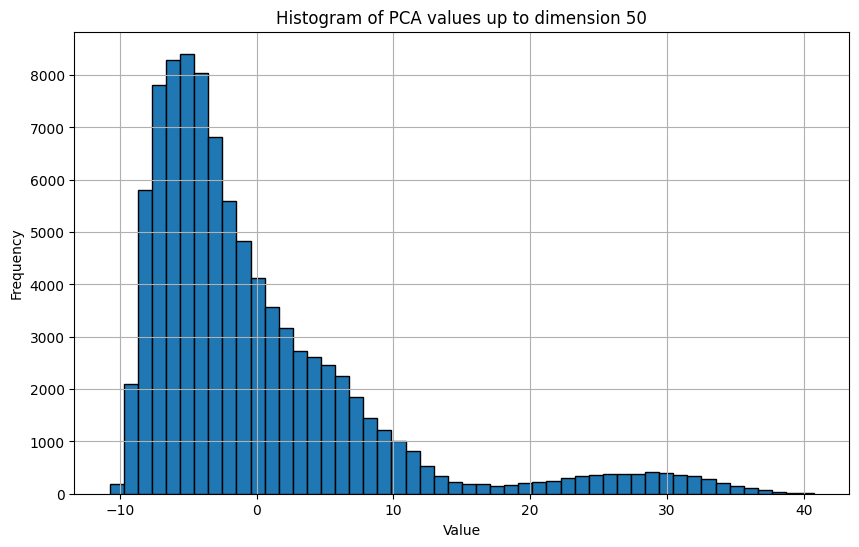

In [11]:
import numpy as np
import matplotlib.pyplot as plt

def plot_histogram(data, bins=100, title="Histogram", xlabel="Value", ylabel="Frequency"):
    """
    Plot a histogram of the given data.

    Parameters:
    data (numpy array): The input data array.
    bins (int): Number of bins for the histogram.
    title (str): Title of the plot.
    xlabel (str): Label for the x-axis.
    ylabel (str): Label for the y-axis.
    """
    plt.figure(figsize=(10, 6))
    plt.hist(data, bins=bins, edgecolor='black')
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.grid(True)
    plt.show()

# first_component_std = np.std(transformed_data[:, 0])
# transformed_data_norm = transformed_data/first_component_std

plot_histogram(transformed_data[:, 0], bins=50, title="Histogram of PCA values up to dimension 50", xlabel="Value", ylabel="Frequency")

# Create HF Datasets

In [2]:
path = "/home/dfl32/project/ifm/cinemaot_data/hvg_normalized_cinemaot.h5ad"
adata = sc.read_h5ad(path)

/home/dfl32/.conda/envs/c2s2/lib/python3.11/site-packages/anndata/_core/anndata.py:1818: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


In [3]:
adata

AnnData object with n_obs × n_vars = 92125 × 5000
    obs: 'perturbation', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'batch', 'chronicity', 'cell_type'
    var: 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'hvg', 'log1p'

In [4]:
adata.obs

perturbation  n_genes  n_genes_by_counts  total_counts  \
AAACCTGAGCGTCTAT-1      IFN-III     1784               1784        4894.0   
AAACCTGGTCCCTACT-1  IFNb + TNFa     2217               2217        5339.0   
AAACCTGGTCCGTCAG-1         IFNb     1890               1890        4571.0   
AAACCTGTCTTCCTTC-1         IL-6     2280               2280        5016.0   
AAACGGGAGCTTTGGT-1  IFNb + TNFa     2188               2188        4980.0   
...                         ...      ...                ...           ...   
TTTGTCATCCGTCAAA-1         IFNg     1252               1252        3251.0   
TTTGTCATCCTAGTGA-1  IFNb + IFNg     1547               1547        3543.0   
TTTGTCATCGATAGAA-1  IFNb + IFNg     1249               1249        3031.0   
TTTGTCATCGGCATCG-1        IFNa2     1252               1252        2959.0   
TTTGTCATCGGTCCGA-1         IL-6     1186               1186        3313.0   

                    total_counts_mt  pct_counts_mt            batch  \
AAACCTGAGCGTCTAT-1            109.0       2.227217    Donor 1 acute   
AAACCTGGTCCCTACT-1             53.0       0.992695    Donor 1 acute   
AAACCTGGTCCGTCAG-1            111.0       2.428353    Donor 1 acute   
AAACCTGTCTTCCTTC-1             34.0       0.677831    Donor 1 acute   
AAACGGGAGCTTTGGT-1             60.0       1.204819    Donor 1 acute   
...                             ...            ...              ...   
TTTGTCATCCGTCAAA-1            156.0       4.798524  Donor 3 chronic   
TTTGTCATCCTAGTGA-1             81.0       2.286198  Donor 3 chronic   
TTTGTCATCGATAGAA-1             72.0       2.375454  Donor 3 chronic   
TTTGTCATCGGCATCG-1             71.0       2.399459  Donor 3 chronic   
TTTGTCATCGGTCCGA-1            114.0       3.440990  Donor 3 chronic   

                   chronicity cell_type  
AAACCTGAGCGTCTAT-1      acute         B  
AAACCTGGTCCCTACT-1      acute     CD4 T  
AAACCTGGTCCGTCAG-1      acute     CD4 T  
AAACCTGTCTTCCTTC-1      acute        NK  
AAACGGGAGCTTTGGT-1      acute        NK  
...                       ...       ...  
TTTGTCATCCGTCAAA-1    chronic        NK  
TTTGTCATCCTAGTGA-1    chronic         B  
TTTGTCATCGATAGAA-1    chronic     CD4 T  
TTTGTCATCGGCATCG-1    chronic     CD4 T  
TTTGTCATCGGTCCGA-1    chronic     CD4 T  

[92125 rows x 9 columns]

In [5]:
adata.obs['chronicity'] = adata.obs['batch'].apply(lambda x: 'acute' if 'acute' in x else 'chronic')

In [10]:
adata.obs

perturbation  n_genes  n_genes_by_counts  total_counts  \
AAACCTGAGCGTCTAT-1      IFN-III     1784               1784        4894.0   
AAACCTGGTCCCTACT-1  IFNb + TNFa     2217               2217        5339.0   
AAACCTGGTCCGTCAG-1         IFNb     1890               1890        4571.0   
AAACCTGTCTTCCTTC-1         IL-6     2280               2280        5016.0   
AAACGGGAGCTTTGGT-1  IFNb + TNFa     2188               2188        4980.0   
...                         ...      ...                ...           ...   
TTTGTCATCCGTCAAA-1         IFNg     1252               1252        3251.0   
TTTGTCATCCTAGTGA-1  IFNb + IFNg     1547               1547        3543.0   
TTTGTCATCGATAGAA-1  IFNb + IFNg     1249               1249        3031.0   
TTTGTCATCGGCATCG-1        IFNa2     1252               1252        2959.0   
TTTGTCATCGGTCCGA-1         IL-6     1186               1186        3313.0   

                    total_counts_mt  pct_counts_mt            batch chronicity  
AAACCTGAGCGTCTAT-1            109.0       2.227217    Donor 1 acute      acute  
AAACCTGGTCCCTACT-1             53.0       0.992695    Donor 1 acute      acute  
AAACCTGGTCCGTCAG-1            111.0       2.428353    Donor 1 acute      acute  
AAACCTGTCTTCCTTC-1             34.0       0.677831    Donor 1 acute      acute  
AAACGGGAGCTTTGGT-1             60.0       1.204819    Donor 1 acute      acute  
...                             ...            ...              ...        ...  
TTTGTCATCCGTCAAA-1            156.0       4.798524  Donor 3 chronic    chronic  
TTTGTCATCCTAGTGA-1             81.0       2.286198  Donor 3 chronic    chronic  
TTTGTCATCGATAGAA-1             72.0       2.375454  Donor 3 chronic    chronic  
TTTGTCATCGGCATCG-1             71.0       2.399459  Donor 3 chronic    chronic  
TTTGTCATCGGTCCGA-1            114.0       3.440990  Donor 3 chronic    chronic  

[92125 rows x 8 columns]

In [14]:
adata.obs[adata.obs['perturbation'] == "No stimulation"]

perturbation  n_genes  n_genes_by_counts  total_counts  \
AAATGCCCAATCAGAA-1  No stimulation     1722               1722        4711.0   
ACGGAGACAGACTCGC-1  No stimulation     1719               1719        4471.0   
AGTCTTTGTGCAACTT-1  No stimulation     1913               1913        3946.0   
CGACTTCCAGATGGGT-1  No stimulation      441                441         606.0   
CGAGCACTCTCGCATC-1  No stimulation     1364               1364        4008.0   
...                            ...      ...                ...           ...   
TTTGGTTAGGACGAAA-1  No stimulation     1257               1257        2819.0   
TTTGGTTGTACCATCA-1  No stimulation     1119               1119        2326.0   
TTTGGTTTCCGCAGTG-1  No stimulation     1213               1213        3376.0   
TTTGTCAGTGTTCGAT-1  No stimulation     1878               1878        5354.0   
TTTGTCAGTTTAAGCC-1  No stimulation     1132               1132        2951.0   

                    total_counts_mt  pct_counts_mt            batch  \
AAATGCCCAATCAGAA-1             55.0       1.167480    Donor 1 acute   
ACGGAGACAGACTCGC-1            169.0       3.779915    Donor 1 acute   
AGTCTTTGTGCAACTT-1            143.0       3.623923    Donor 1 acute   
CGACTTCCAGATGGGT-1             30.0       4.950495    Donor 1 acute   
CGAGCACTCTCGCATC-1            112.0       2.794411    Donor 1 acute   
...                             ...            ...              ...   
TTTGGTTAGGACGAAA-1             99.0       3.511884  Donor 3 chronic   
TTTGGTTGTACCATCA-1             67.0       2.880481  Donor 3 chronic   
TTTGGTTTCCGCAGTG-1            157.0       4.650474  Donor 3 chronic   
TTTGTCAGTGTTCGAT-1            163.0       3.044453  Donor 3 chronic   
TTTGTCAGTTTAAGCC-1            119.0       4.032531  Donor 3 chronic   

                   chronicity cell_type  
AAATGCCCAATCAGAA-1      acute     CD4 T  
ACGGAGACAGACTCGC-1      acute     CD4 T  
AGTCTTTGTGCAACTT-1      acute        NK  
CGACTTCCAGATGGGT-1      acute     CD4 T  
CGAGCACTCTCGCATC-1      acute     CD4 T  
...                       ...       ...  
TTTGGTTAGGACGAAA-1    chronic     CD8 T  
TTTGGTTGTACCATCA-1    chronic        NK  
TTTGGTTTCCGCAGTG-1    chronic     CD4 T  
TTTGTCAGTGTTCGAT-1    chronic     CD4 T  
TTTGTCAGTTTAAGCC-1    chronic     CD8 T  

[9625 rows x 9 columns]

PCA DONE
KNN DONE
UMAP DONE


/home/dfl32/.conda/envs/c2s2/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:1234: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
/home/dfl32/.conda/envs/c2s2/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


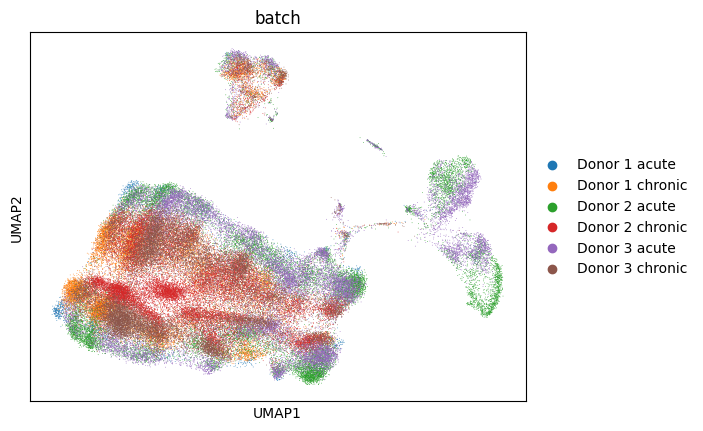

In [8]:
sc.pp.pca(adata)
print("PCA DONE")
sc.pp.neighbors(adata)
print("KNN DONE")
sc.tl.umap(adata)
print("UMAP DONE")
sc.pl.umap(adata, color=['batch'])

/home/dfl32/.conda/envs/c2s2/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:1234: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
/home/dfl32/.conda/envs/c2s2/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


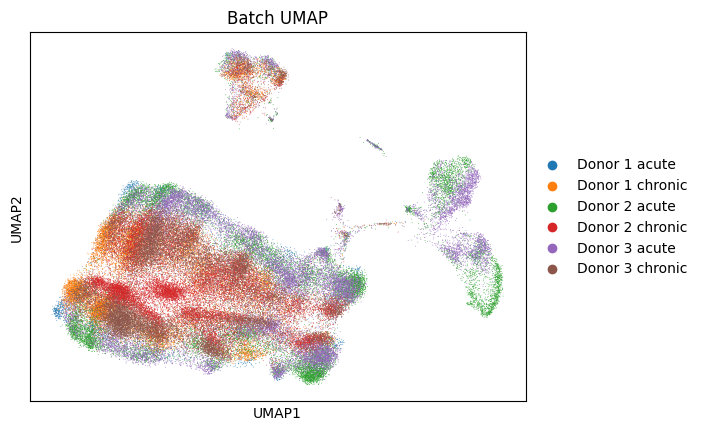

In [12]:
sc.pl.umap(adata, color=['batch'], title="Batch UMAP")

/home/dfl32/.conda/envs/c2s2/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:1234: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
/home/dfl32/.conda/envs/c2s2/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


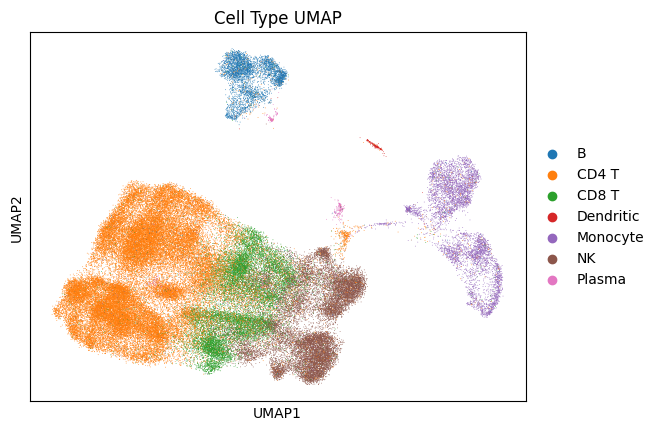

In [13]:
sc.pl.umap(adata, color=['cell_type'], title='Cell Type UMAP')

/home/dfl32/.conda/envs/c2s2/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:1234: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
/home/dfl32/.conda/envs/c2s2/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


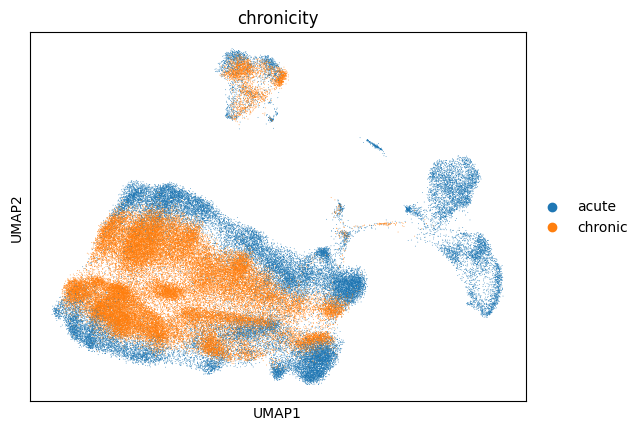

In [10]:
sc.pl.umap(adata, color=['chronicity'])

In [19]:
adata_ctr = adata[adata.obs['perturbation'] != 'No stimulation'].copy()

/home/dfl32/.conda/envs/c2s2/lib/python3.11/site-packages/anndata/_core/anndata.py:1818: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


PCA DONE
KNN DONE
UMAP DONE


/home/dfl32/.conda/envs/c2s2/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:1234: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
/home/dfl32/.conda/envs/c2s2/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


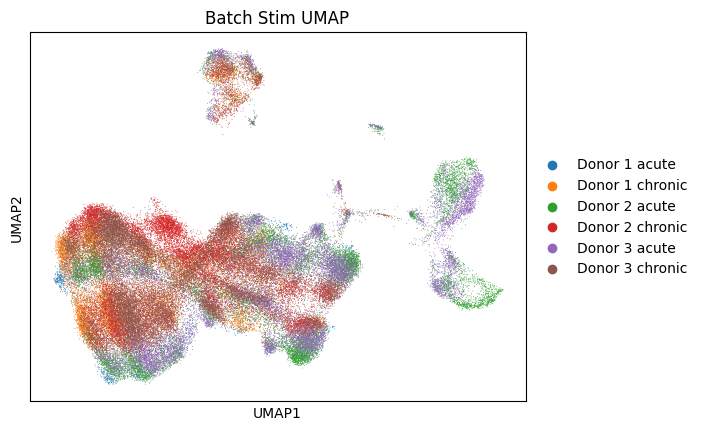

In [20]:
sc.pp.pca(adata_ctr)
print("PCA DONE")
sc.pp.neighbors(adata_ctr)
print("KNN DONE")
sc.tl.umap(adata_ctr)
print("UMAP DONE")
sc.pl.umap(adata_ctr, color=['batch'], title='Batch Stim UMAP')

/home/dfl32/.conda/envs/c2s2/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:1234: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
/home/dfl32/.conda/envs/c2s2/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


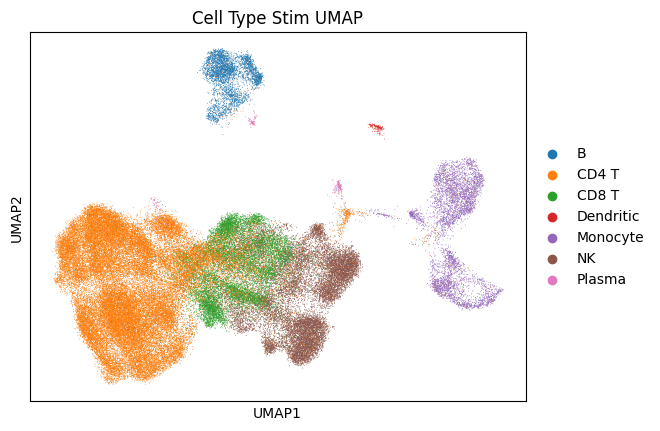

In [21]:
sc.pl.umap(adata_ctr, color=['cell_type'], title='Cell Type Stim UMAP')

/home/dfl32/.conda/envs/c2s2/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:1234: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
/home/dfl32/.conda/envs/c2s2/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


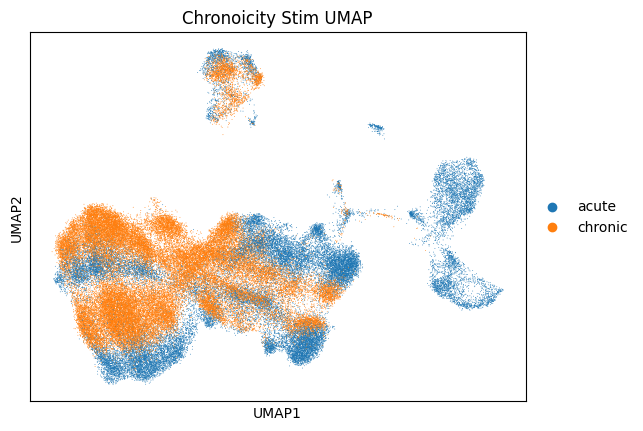

In [22]:
sc.pl.umap(adata_ctr, color=['chronicity'], title='Chronoicity Stim UMAP')

In [6]:
value_counts = adata.obs[adata.obs['perturbation'] == "No stimulation"].groupby(['batch', 'cell_type']).size().reset_index(name='count')
value_counts = adata.obs[adata.obs['perturbation'] == "No stimulation"].groupby(['batch', 'cell_type']).size().reset_index(name='count')

/tmp/ipykernel_1241288/1779905428.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  value_counts = adata.obs[adata.obs['perturbation'] == "No stimulation"].groupby(['batch', 'cell_type']).size().reset_index(name='count')


In [7]:
value_counts

batch  cell_type  count
0     Donor 1 acute          B      0
1     Donor 1 acute      CD4 T      8
2     Donor 1 acute      CD8 T      0
3     Donor 1 acute  Dendritic      0
4     Donor 1 acute   Monocyte      0
5     Donor 1 acute         NK      2
6     Donor 1 acute     Plasma      0
7   Donor 1 chronic          B    136
8   Donor 1 chronic      CD4 T   1480
9   Donor 1 chronic      CD8 T    180
10  Donor 1 chronic  Dendritic      0
11  Donor 1 chronic   Monocyte     10
12  Donor 1 chronic         NK    221
13  Donor 1 chronic     Plasma      0
14    Donor 2 acute          B     61
15    Donor 2 acute      CD4 T    614
16    Donor 2 acute      CD8 T    263
17    Donor 2 acute  Dendritic      3
18    Donor 2 acute   Monocyte    376
19    Donor 2 acute         NK    519
20    Donor 2 acute     Plasma      1
21  Donor 2 chronic          B     66
22  Donor 2 chronic      CD4 T   1457
23  Donor 2 chronic      CD8 T    354
24  Donor 2 chronic  Dendritic      0
25  Donor 2 chronic   Monocyte      8
26  Donor 2 chronic         NK    281
27  Donor 2 chronic     Plasma      6
28    Donor 3 acute          B     90
29    Donor 3 acute      CD4 T    580
30    Donor 3 acute      CD8 T    292
31    Donor 3 acute  Dendritic      4
32    Donor 3 acute   Monocyte    280
33    Donor 3 acute         NK    623
34    Donor 3 acute     Plasma     13
35  Donor 3 chronic          B     60
36  Donor 3 chronic      CD4 T   1236
37  Donor 3 chronic      CD8 T    289
38  Donor 3 chronic  Dendritic      0
39  Donor 3 chronic   Monocyte     16
40  Donor 3 chronic         NK     94
41  Donor 3 chronic     Plasma      2

In [6]:
adata_pert = adata[adata.obs['perturbation'] != "No stimulation"].copy()
adata_ctr = adata[adata.obs['perturbation'] == "No stimulation"].copy()

/home/dfl32/.conda/envs/c2s2/lib/python3.11/site-packages/anndata/_core/anndata.py:1818: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


In [7]:
import numpy as np
import pandas as pd
from datasets import Dataset

# Step 1: Extract data from adata_pert
pert_expr = adata_pert.X.toarray() if hasattr(adata_pert.X, "toarray") else adata_pert.X
perturbations = adata_pert.obs['perturbation'].values  # Assuming 'perturbation' is a column of strings
cell_types_pert = adata_pert.obs['cell_type'].values  # Assuming 'cell_type' is a column of strings

# Step 2: Prepare to find matching cells in adata_ctr
# Create a mapping from cell type to indices in adata_ctr
cell_type_to_indices = {}
for idx, cell_type in enumerate(adata_ctr.obs['cell_type']):
    if cell_type not in cell_type_to_indices:
        cell_type_to_indices[cell_type] = []
    cell_type_to_indices[cell_type].append(idx)

# Function to get random control expression for a given cell type
def get_random_ctr_expr(cell_type):
    if cell_type in cell_type_to_indices:
        idxs = cell_type_to_indices[cell_type]
        random_idx = np.random.choice(idxs)
        return adata_ctr.X[random_idx].toarray() if hasattr(adata_ctr.X, "toarray") else adata_ctr.X[random_idx]
    else:
        # Handle case where no matching cell type is found
        return np.nan * np.ones(adata_ctr.X.shape[1])

# Step 3: Construct dataset entries
data_entries = []
for pert_exp, pert, cell_type in zip(pert_expr, perturbations, cell_types_pert):
    ctr_exp = get_random_ctr_expr(cell_type)
    data_entries.append({
        "pert_expr": pert_exp,
        "ctr_expr": ctr_exp,
        "perturbation": pert,
        "cell_type": cell_type
    })

# Step 4: Create hugging face dataset
dataset = Dataset.from_pandas(pd.DataFrame(data_entries))

# Display the first few rows of the dataset to verify
print(dataset)


Dataset({
    features: ['pert_expr', 'ctr_expr', 'perturbation', 'cell_type'],
    num_rows: 82500
})


In [8]:
import numpy as np
import pandas as pd
from datasets import Dataset, concatenate_datasets

# Function to get random control expression for a given cell type
def get_random_ctr_expr(cell_type, cell_type_to_indices):
    if cell_type in cell_type_to_indices:
        idxs = cell_type_to_indices[cell_type]
        random_idx = np.random.choice(idxs)
        return adata_ctr.X[random_idx].toarray() if hasattr(adata_ctr.X, "toarray") else adata_ctr.X[random_idx]
    else:
        # Handle case where no matching cell type is found
        return np.nan * np.ones(adata_ctr.X.shape[1])

# Main process function
def generate_dataset(adata_pert, adata_ctr):
    pert_expr = adata_pert.X.toarray() if hasattr(adata_pert.X, "toarray") else adata_pert.X
    perturbations = adata_pert.obs['perturbation'].values
    cell_types_pert = adata_pert.obs['cell_type'].values

    # Create a mapping from cell type to indices in adata_ctr
    cell_type_to_indices = {cell_type: [] for cell_type in adata_ctr.obs['cell_type'].unique()}
    for idx, cell_type in enumerate(adata_ctr.obs['cell_type']):
        cell_type_to_indices[cell_type].append(idx)

    data_entries = []
    for pert_exp, pert, cell_type in zip(pert_expr, perturbations, cell_types_pert):
        ctr_exp = get_random_ctr_expr(cell_type, cell_type_to_indices)
        data_entries.append({
            "pert_expr": pert_exp,
            "ctr_expr": ctr_exp,
            "perturbation": pert,
            "cell_type": cell_type
        })

    # Shuffle entries before returning
    np.random.shuffle(data_entries)

    return Dataset.from_pandas(pd.DataFrame(data_entries))

# # Repeat the process 50 times and concatenate
# datasets = [generate_dataset(adata_pert, adata_ctr) for _ in range(50)]
# concatenated_dataset = concatenate_datasets(datasets)

# # Display information about the concatenated dataset
# print(concatenated_dataset)

dataset = generate_dataset(adata_pert, adata_ctr)
print(dataset)

Dataset({
    features: ['pert_expr', 'ctr_expr', 'perturbation', 'cell_type'],
    num_rows: 82500
})


In [10]:
data_dir = "/home/dfl32/scratch/cinemaot_data/ifm_hf_ds"
fn = "hf_one_ep_ds"
fp = os.path.join(data_dir, fn)

dataset.save_to_disk(fp)

Saving the dataset (0/7 shards):   0%|          | 0/82500 [00:00<?, ? examples/s]

# Dataset analysis

In [4]:
adata_file_path = "/home/dfl32/project/ifm/cinemaot_data/hvg_normalized_cinemaot.h5ad"
scvi_checkpoint = "/home/dfl32/project/ifm/scvi_models/epoch99_layers3_latent30_hidden128model.pt"
adata = sc.read_h5ad(adata_file_path)

test_combos = combo_split_nochron()
adata.obs['cell_type_perturbation'] = list(zip(adata.obs['cell_type'], adata.obs['perturbation']))
train_adata = adata[~adata.obs['cell_type_perturbation'].isin(test_combos)].copy()
train_adata.obs.drop(columns=['cell_type_perturbation'], inplace=True)
adata_all_perts = train_adata[train_adata.obs['perturbation']!='No stimulation'].copy()

scvi.model.SCVI.setup_anndata(train_adata)
scvi_model_cp_dir = "/".join(scvi_checkpoint.split("/")[:-1])
scvi_model_cp_prefix = scvi_checkpoint.split("/")[-1][:-8]
vae = scvi.model.SCVI.load(scvi_model_cp_dir, adata=train_adata, accelerator='gpu', prefix=scvi_model_cp_prefix)

/home/dfl32/.conda/envs/c2s2/lib/python3.11/site-packages/anndata/_core/anndata.py:1818: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")
/home/dfl32/.conda/envs/c2s2/lib/python3.11/site-packages/anndata/_core/anndata.py:1818: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")
/home/dfl32/.conda/envs/c2s2/lib/python3.11/site-packages/anndata/_core/anndata.py:1818: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")
2024-05-07 15:33:13.126290: E external/xla/xla/stream_executor/cuda/cuda_driver.cc:282] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
/home/dfl32/.conda/envs/c2s2/lib/python3.11/site-packages/torch/cuda/__init__.py:628: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NV

MisconfigurationException: No supported gpu backend found!

In [3]:
adata_all_perts = train_adata[train_adata.obs['perturbation']!='No stimulation'].copy()
samples = vae.posterior_predictive_sample(adata=adata_all_perts)
gen = samples.todense()
gen_adata = anndata.AnnData(X=gen, obs=adata_all_perts.obs, var=adata_all_perts.var)

adata_all_perts.obs['sample'] = ['ground truth']*len(adata_all_perts)
gen_adata.obs['sample'] = ['scvi generated']*len(gen_adata)
all_adata = anndata.concat([adata_all_perts, gen_adata])
data = np.concatenate([adata_all_perts.X, gen], axis=0)

INFO     AnnData object appears to be a copy. Attempting to transfer setup.                                        


/home/dfl32/.conda/envs/c2s2/lib/python3.11/site-packages/anndata/_core/anndata.py:1818: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")
/home/dfl32/.conda/envs/c2s2/lib/python3.11/site-packages/anndata/_core/anndata.py:1818: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")
/home/dfl32/.conda/envs/c2s2/lib/python3.11/site-packages/anndata/_core/anndata.py:1818: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


In [4]:
cp_num = 35400
time_points = 2

In [32]:
data_dir = "/home/dfl32/project/ifm/data"
save_fn = f"gen_cells_norm_cp{cp_num}_tp{time_points}.pickle"
save_path = os.path.join(data_dir, save_fn)

with open(save_path, "rb") as f:
    perturbed_cells_dict = pickle.load(f)

all_perts = [perturbed_cells_dict[key] for key in perturbed_cells_dict]
combo_labels = []
cell_type_labels = []
pert_labels = []
for key in perturbed_cells_dict:
    combo_labels += [key]*len(perturbed_cells_dict[key])
    cell_type_labels += [key[0]]*len(perturbed_cells_dict[key])
    pert_labels += [key[1]]*len(perturbed_cells_dict[key])
all_perts = np.concatenate(all_perts, axis=0)
ifm_norm_adata = anndata.AnnData(X=all_perts)
ifm_norm_adata.obs['cell_type'] = cell_type_labels
ifm_norm_adata.obs['perturbation'] = pert_labels
ifm_norm_adata.obs['sample'] = ['ifm']*len(ifm_norm_adata)
ifm_norm_adata = ifm_norm_adata[ifm_norm_adata.obs['perturbation'] != 'No stimulation'].copy()
simple_adata_all_perts = anndata.AnnData(X=adata_all_perts.X)
simple_adata_all_perts.obs['cell_type'] = list(adata_all_perts.obs['cell_type'])
simple_adata_all_perts.obs['perturbation'] = list(adata_all_perts.obs['perturbation'])
simple_adata_all_perts.obs['sample'] = ['train data']*len(simple_adata_all_perts)
combined_norm_adata = anndata.concat([simple_adata_all_perts, ifm_norm_adata])

/home/dfl32/.conda/envs/c2s2/lib/python3.11/site-packages/anndata/_core/anndata.py:1818: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


In [33]:
combined_norm_adata

AnnData object with n_obs × n_vars = 132298 × 5000
    obs: 'cell_type', 'perturbation', 'sample'

/home/dfl32/.conda/envs/c2s2/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:1234: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
/home/dfl32/.conda/envs/c2s2/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/home/dfl32/.conda/envs/c2s2/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:1234: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
/

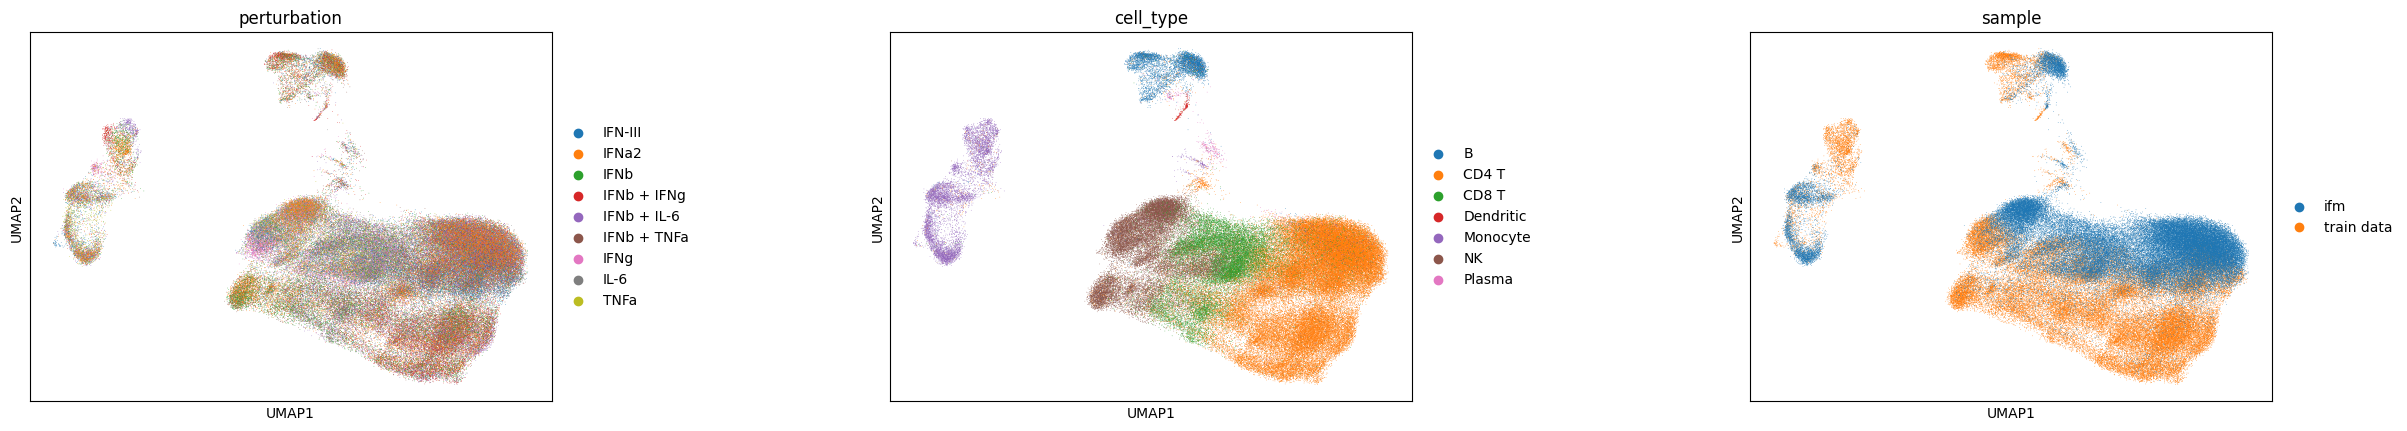

In [34]:
sc.pp.pca(combined_norm_adata)
sc.pp.neighbors(combined_norm_adata)
sc.tl.umap(combined_norm_adata)
sc.pl.umap(combined_norm_adata, color=['perturbation', 'cell_type', 'sample'], wspace=0.5)

In [5]:
expr_vecs = torch.tensor(adata_all_perts.X).to('cuda')
cat_input = torch.tensor([0]*expr_vecs.shape[0]).to('cuda')

z_embs = vae.module.z_encoder.encoder(expr_vecs,cat_input)
z_embs = z_embs.detach().cpu().numpy()

In [6]:
data_dir = "/home/dfl32/project/ifm/data"
save_fn = f"gen_embs_norm_cp{cp_num}_tp{time_points}.pickle"
save_path = os.path.join(data_dir, save_fn)

with open(save_path, "rb") as f:
    z_dict = pickle.load(f)

all_z_perts = [z_dict[key] for key in z_dict]
combo_labels = []
cell_type_labels = []
pert_labels = []
for key in z_dict:
    combo_labels += [key]*len(z_dict[key])
    cell_type_labels += [key[0]]*len(z_dict[key])
    pert_labels += [key[1]]*len(z_dict[key])
all_z_perts = np.concatenate(all_z_perts, axis=0)
ifm_norm_z_adata = anndata.AnnData(X=all_z_perts)
ifm_norm_z_adata.obs['cell_type'] = cell_type_labels
ifm_norm_z_adata.obs['perturbation'] = pert_labels
ifm_norm_z_adata.obs['sample'] = ['ifm']*len(ifm_norm_z_adata)
ifm_norm_z_adata = ifm_norm_z_adata[ifm_norm_z_adata.obs['perturbation'] != 'No stimulation'].copy()
simple_adata_all_z_perts = anndata.AnnData(X=z_embs)
simple_adata_all_z_perts.obs['cell_type'] = list(adata_all_perts.obs['cell_type'])
simple_adata_all_z_perts.obs['perturbation'] = list(adata_all_perts.obs['perturbation'])
simple_adata_all_z_perts.obs['sample'] = ['train data']*len(simple_adata_all_z_perts)
combined_norm_z_adata = anndata.concat([simple_adata_all_z_perts, ifm_norm_z_adata])

/home/dfl32/.conda/envs/c2s2/lib/python3.11/site-packages/anndata/_core/anndata.py:1818: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


/home/dfl32/.conda/envs/c2s2/lib/python3.11/site-packages/umap/spectral.py:550: UserWarning: Spectral initialisation failed! The eigenvector solver
failed. This is likely due to too small an eigengap. Consider
adding some noise or jitter to your data.

Falling back to random initialisation!
  warn(
/home/dfl32/.conda/envs/c2s2/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:1234: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
/home/dfl32/.conda/envs/c2s2/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/home/dfl32/.conda/envs/c2s2/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py

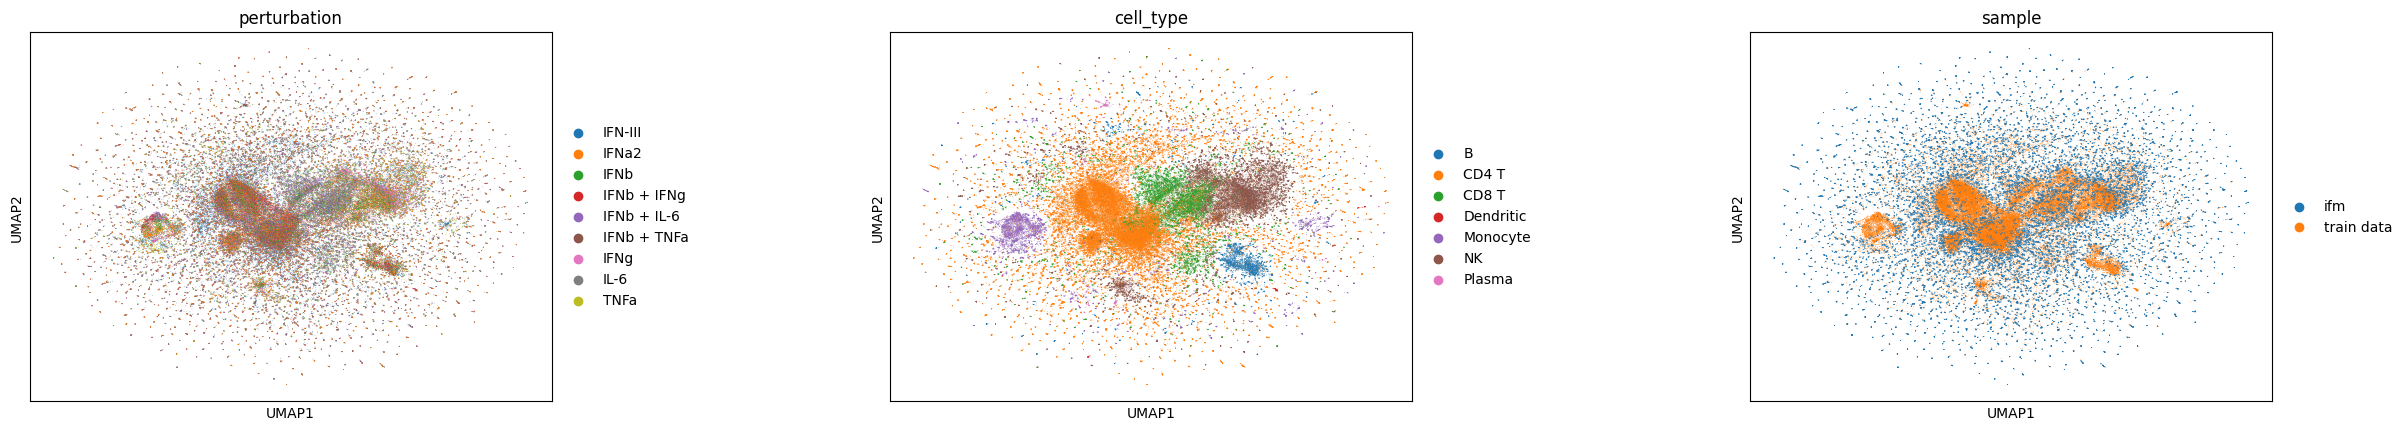

In [7]:
sc.pp.pca(combined_norm_z_adata)
sc.pp.neighbors(combined_norm_z_adata)
sc.tl.umap(combined_norm_z_adata)
sc.pl.umap(combined_norm_z_adata, color=['perturbation', 'cell_type', 'sample'], wspace=0.5)

/home/dfl32/.conda/envs/c2s2/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:1234: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
/home/dfl32/.conda/envs/c2s2/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


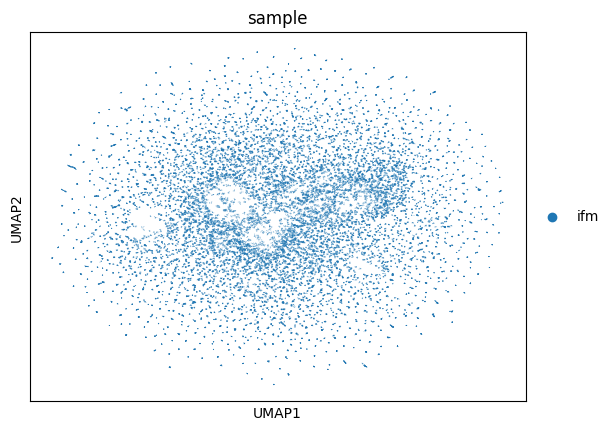

In [8]:
# Load your AnnData object
adata = combined_norm_z_adata

# Subset data by sample
adata_sample1 = adata[adata.obs['sample'] == 'ifm']
adata_sample2 = adata[adata.obs['sample'] == 'train data']

# Start a UMAP plot with the first subset
ax = sc.pl.umap(adata_sample1, color='sample', alpha=0.5, show=False, wspace=0.5)

# # Overlay the second subset on the same axis with different alpha
# sc.pl.umap(adata_sample2, color='sample', alpha=0.8, show=True, ax=ax, wspace=0.5)

/home/dfl32/.conda/envs/c2s2/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:1234: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
/home/dfl32/.conda/envs/c2s2/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


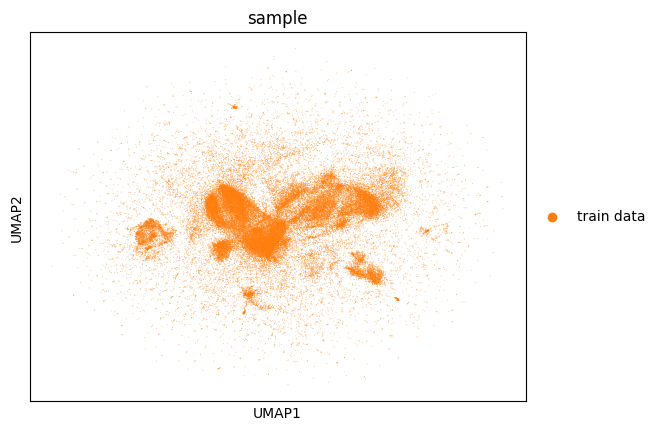

In [10]:
# # Overlay the second subset on the same axis with different alpha
sc.pl.umap(adata_sample2, color='sample', alpha=0.5, show=True, wspace=0.5)

/home/dfl32/.conda/envs/c2s2/lib/python3.11/site-packages/scanpy/preprocessing/_pca.py:229: ImplicitModificationWarning: Setting element `.obsm['X_pca']` of view, initializing view as actual.
  adata.obsm['X_pca'] = X_pca
/home/dfl32/.conda/envs/c2s2/lib/python3.11/site-packages/anndata/_core/anndata.py:1818: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")
/home/dfl32/.conda/envs/c2s2/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:1234: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
/home/dfl32/.conda/envs/c2s2/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. 

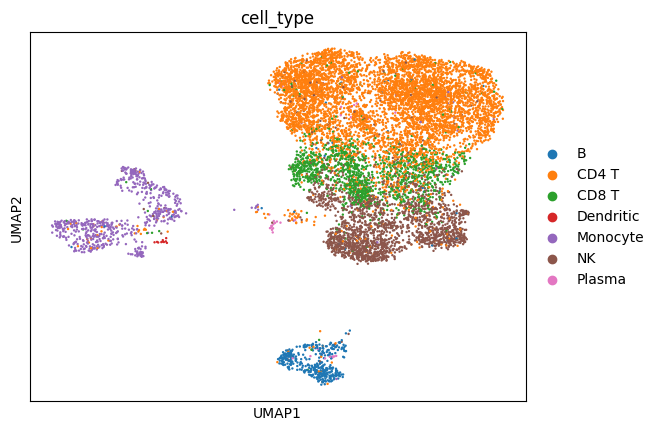

In [14]:
adata_pert = train_adata
num_samples = 10000
indices = np.random.choice(adata_pert.shape[0], size=num_samples, replace=False)
sampled_adata = adata_pert[indices, :]

sc.pp.pca(sampled_adata)
sc.pp.neighbors(sampled_adata)
sc.tl.umap(sampled_adata)
sc.pl.umap(sampled_adata, color=['cell_type'], wspace=0.5)

/home/dfl32/.conda/envs/c2s2/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:1234: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
/home/dfl32/.conda/envs/c2s2/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


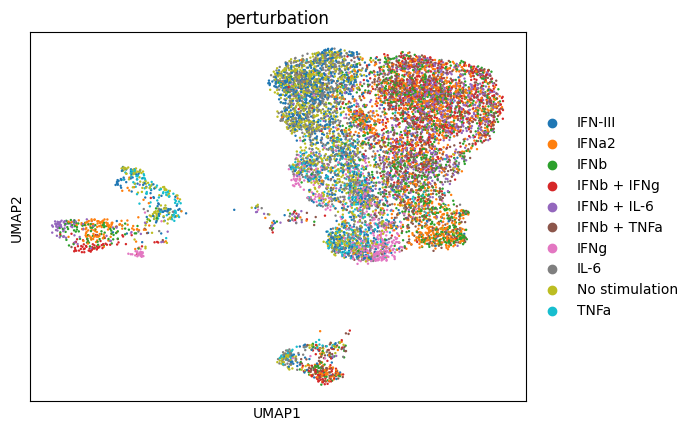

In [15]:
sc.pl.umap(sampled_adata, color=['perturbation'], wspace=0.5)

In [24]:
sc.pl.umap(sampled_adata[sampled_adata.obs['perturbation'] != 'No stimulation'], color='blue', use_raw=True, wspace=0.5)

ValueError: `use_raw` is set to True but AnnData object does not have raw. Please check.

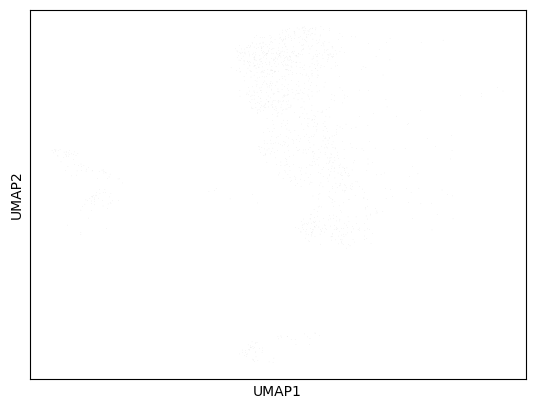

In [22]:
sc.pl.umap(sampled_adata[sampled_adata.obs['perturbation'] == 'No stimulation'], wspace=0.5, s=0.5)

# Misc

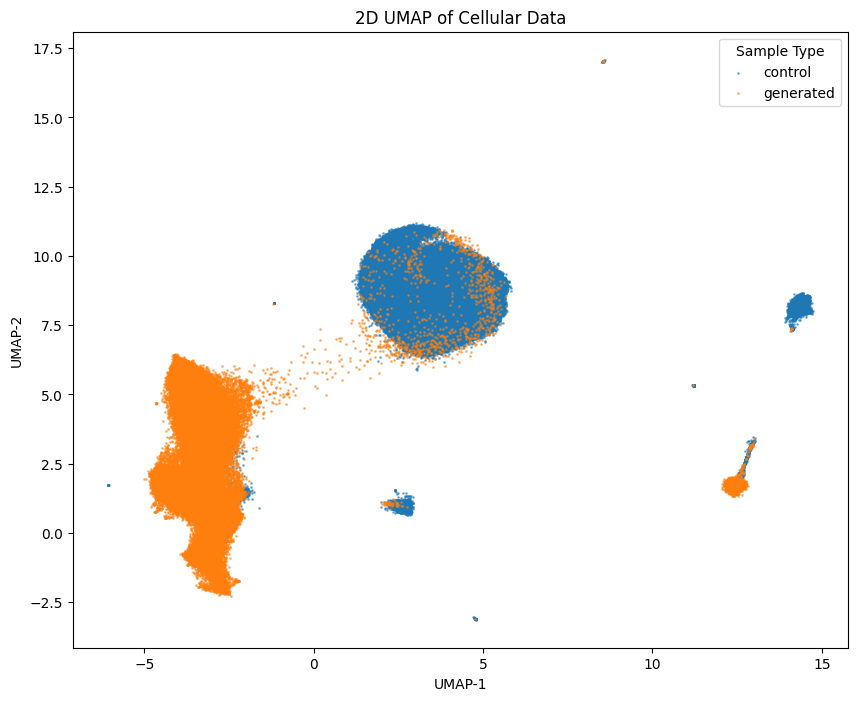

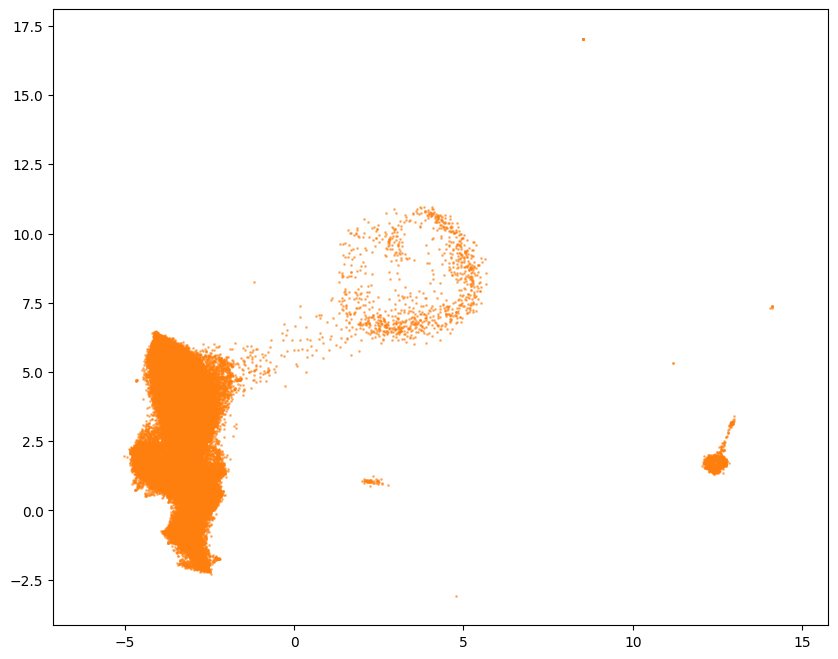

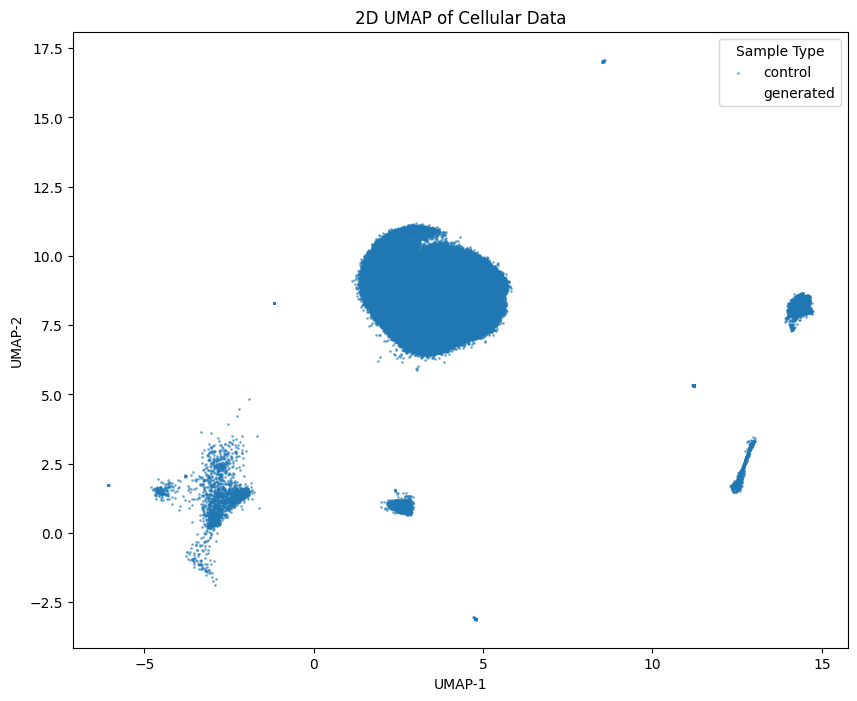

In [24]:
# Plotting
plt.figure(figsize=(10, 8))
for label in np.unique(labels):
    idx = labels == label
    plt.scatter(embedding[idx, 0], embedding[idx, 1], label=label, alpha=0.5, s=1)

plt.title('2D UMAP of Cellular Data')
plt.xlabel('UMAP-1')
plt.ylabel('UMAP-2')
plt.legend(title='Sample Type')
plt.show()

# Plotting
plt.figure(figsize=(10, 8))
for label in np.unique(labels):
    alpha = 0.5
    if label == 'control':
        alpha = 0.0
    idx = labels == label
    plt.scatter(embedding[idx, 0], embedding[idx, 1], label=label, alpha=alpha, s=1)

# Plotting
plt.figure(figsize=(10, 8))
for label in np.unique(labels):
    if label == 'generated':
        alpha = 0.0
    idx = labels == label
    plt.scatter(embedding[idx, 0], embedding[idx, 1], label=label, alpha=alpha, s=1)

plt.title('2D UMAP of Cellular Data')
plt.xlabel('UMAP-1')
plt.ylabel('UMAP-2')
plt.legend(title='Sample Type')
plt.show()

In [28]:
import torch

def generate_paths(X_0, X_1, sigma=0.1, time_points=16):
    # Convert lists to tensors
    X_0 = torch.tensor(X_0, dtype=torch.float32)
    X_1 = torch.tensor(X_1, dtype=torch.float32)
    
    # Dimensions
    dim = len(X_0)  # Here dim is 5000
    
    # Generate time points: from 0 to 1, including both endpoints, evenly spaced
    times = torch.linspace(0, 1, steps=time_points).view(time_points, 1)
    
    # Expand times and inputs to broadcast across dimensions
    times_expanded = times.expand(time_points, dim)
    
    # Linear interpolation: tX_1 + (1-t)X_0 = X_0 + t(X_1 - X_0)
    path_means = X_0 + times_expanded * (X_1 - X_0)
    
    # Initialize paths with means (ensures exact start at X_0 and end at X_1)
    paths = path_means.clone()
    
    # Gaussian noise: zero mean, sigma standard deviation, but not for the first and last time points
    if time_points > 2:
        noise = sigma * torch.randn(time_points-2, dim)
        
        # Determine where X_0 or X_1 is non-zero, for intermediate time points
        non_zero_mask = ((X_0 != 0) | (X_1 != 0))
        non_zero_mask_expanded = non_zero_mask.unsqueeze(0).expand(time_points-2, -1)
        
        # Apply noise only where non_zero_mask is True, and only to intermediate points
        paths[1:-1] = paths[1:-1].where(~non_zero_mask_expanded, paths[1:-1] + noise)

    return paths

# Example usage:
X_0 = [0.0]*2500 + [1.0]*2500  # Example list of 5000 elements
X_1 = [0.0]*2500 + [0.5]*2500

paths = generate_paths(X_0, X_1)
print(paths.shape)  # Should print torch.Size([16, 5000])


torch.Size([16, 5000])


In [29]:
paths

tensor([[0.0000, 0.0000, 0.0000,  ..., 1.0000, 1.0000, 1.0000],
        [0.0000, 0.0000, 0.0000,  ..., 0.9632, 0.9058, 1.0142],
        [0.0000, 0.0000, 0.0000,  ..., 1.2132, 0.8578, 0.8722],
        ...,
        [0.0000, 0.0000, 0.0000,  ..., 0.5845, 0.6529, 0.6022],
        [0.0000, 0.0000, 0.0000,  ..., 0.4942, 0.6384, 0.3544],
        [0.0000, 0.0000, 0.0000,  ..., 0.5000, 0.5000, 0.5000]])

In [27]:
expr_vecs = torch.tensor(adata_all_perts.X).to('cuda')
cat_input = torch.tensor([0]*expr_vecs.shape[0]).to('cuda')

z_embs = vae.module.z_encoder.encoder(expr_vecs,cat_input)

In [37]:
(z_embs == 0).sum()/z_embs.shape[0]

tensor(58.2495, device='cuda:0')

In [33]:
vae.module.z_encoder.encoder

FCLayers(
  (fc_layers): Sequential(
    (Layer 0): Sequential(
      (0): Linear(in_features=5000, out_features=128, bias=True)
      (1): None
      (2): LayerNorm((128,), eps=1e-05, elementwise_affine=False)
      (3): ReLU()
      (4): Dropout(p=0.2, inplace=False)
    )
    (Layer 1): Sequential(
      (0): Linear(in_features=128, out_features=128, bias=True)
      (1): None
      (2): LayerNorm((128,), eps=1e-05, elementwise_affine=False)
      (3): ReLU()
      (4): Dropout(p=0.2, inplace=False)
    )
    (Layer 2): Sequential(
      (0): Linear(in_features=128, out_features=128, bias=True)
      (1): None
      (2): LayerNorm((128,), eps=1e-05, elementwise_affine=False)
      (3): ReLU()
      (4): Dropout(p=0.2, inplace=False)
    )
  )
)

In [35]:
from transformers import AutoModelForCausalLM

model_name = "EleutherAI/pythia-160m"

model = AutoModelForCausalLM.from_pretrained(model_name)

In [36]:
model

GPTNeoXForCausalLM(
  (gpt_neox): GPTNeoXModel(
    (embed_in): Embedding(50304, 768)
    (emb_dropout): Dropout(p=0.0, inplace=False)
    (layers): ModuleList(
      (0-11): 12 x GPTNeoXLayer(
        (input_layernorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (post_attention_layernorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (post_attention_dropout): Dropout(p=0.0, inplace=False)
        (post_mlp_dropout): Dropout(p=0.0, inplace=False)
        (attention): GPTNeoXAttention(
          (rotary_emb): GPTNeoXRotaryEmbedding()
          (query_key_value): Linear(in_features=768, out_features=2304, bias=True)
          (dense): Linear(in_features=768, out_features=768, bias=True)
          (attention_dropout): Dropout(p=0.0, inplace=False)
        )
        (mlp): GPTNeoXMLP(
          (dense_h_to_4h): Linear(in_features=768, out_features=3072, bias=True)
          (dense_4h_to_h): Linear(in_features=3072, out_features=768, bias=True)
          

# Old cells

In [8]:
data_dir = "/home/dfl32/scratch/cinemaot_data/ifm_hf_ds"
fn = "hf_one_ep_ds"
fp = os.path.join(data_dir, fn)

ds = load_from_disk(fp)

In [8]:
ds_cell = ds.filter(lambda example: example['cell_type'] == 'CD4 T')

Filter:   0%|          | 0/82500 [00:00<?, ? examples/s]

In [9]:
ds_cell

Dataset({
    features: ['pert_expr', 'ctr_expr', 'perturbation', 'cell_type'],
    num_rows: 44850
})

In [13]:
ds_cell_pert = ds_cell.filter(lambda example: example['perturbation'] == 'IFNb')

Filter:   0%|          | 0/44850 [00:00<?, ? examples/s]

In [15]:
ctr_expr = ds_cell_pert['ctr_expr']
pert_expr = ds_cell_pert['pert_expr']

In [19]:
ctr_expr_np = np.array(ctr_expr)
pert_expr_np = np.array(pert_expr)

In [21]:
pert_expr_np.shape

(4818, 5000)

In [26]:
mean_pert = pert_expr_np.mean(axis=0).reshape(1,-1)
mean_pert.shape

(1, 5000)

In [31]:
# Set the variance
variance = 0.01
std_dev = np.sqrt(variance)

# Generate the 5000 similar vectors
samples = np.random.normal(loc=mean_pert, scale=std_dev, size=(5000, 1, 5000))

# Reshape if necessary to (5000, 5000)
mean_samples = samples.reshape(5000, 5000)

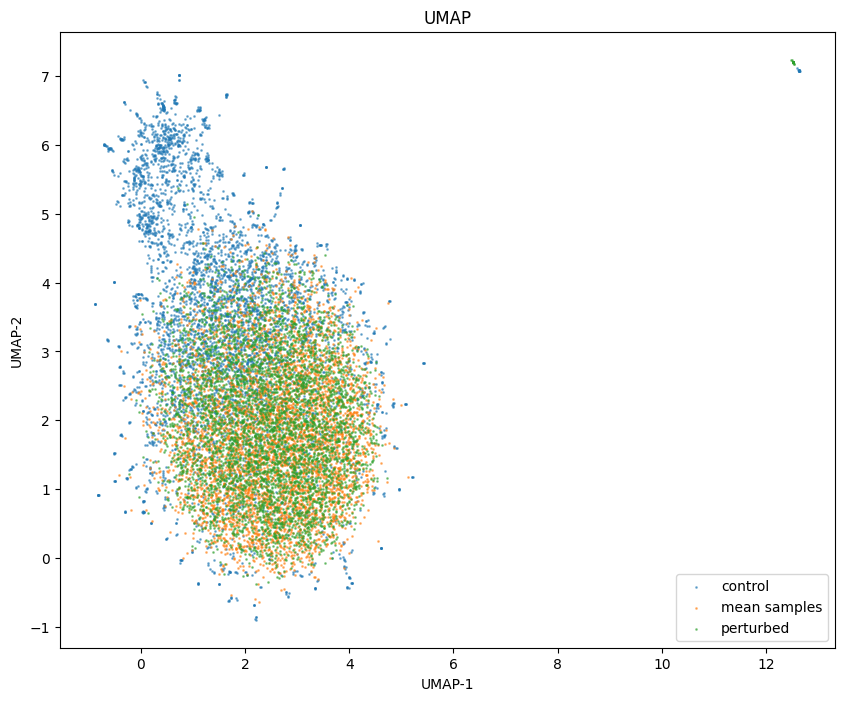

In [32]:
data = np.concatenate([ctr_expr_np, pert_expr_np, mean_samples], axis=0)

# Create a color/label array
# Assuming the number of samples in each array is ctr_expr.shape[0], gt_pert_np.shape[0], perturbed_cells_np.shape[0]
labels = np.concatenate([
    np.full(ctr_expr_np.shape[0], 'control'),
    np.full(pert_expr_np.shape[0], 'perturbed'),
    np.full(mean_samples.shape[0], 'mean samples')
])

# UMAP reduction
reducer = umap.UMAP()
embedding = reducer.fit_transform(data)

# Plotting
plt.figure(figsize=(10, 8))
for label in np.unique(labels):
    alpha = 0.5
    size = 1
    idx = labels == label
    plt.scatter(embedding[idx, 0], embedding[idx, 1], label=label, alpha=alpha, s=size)

plt.title('UMAP')
plt.xlabel('UMAP-1')
plt.ylabel('UMAP-2')
plt.legend()
plt.show()

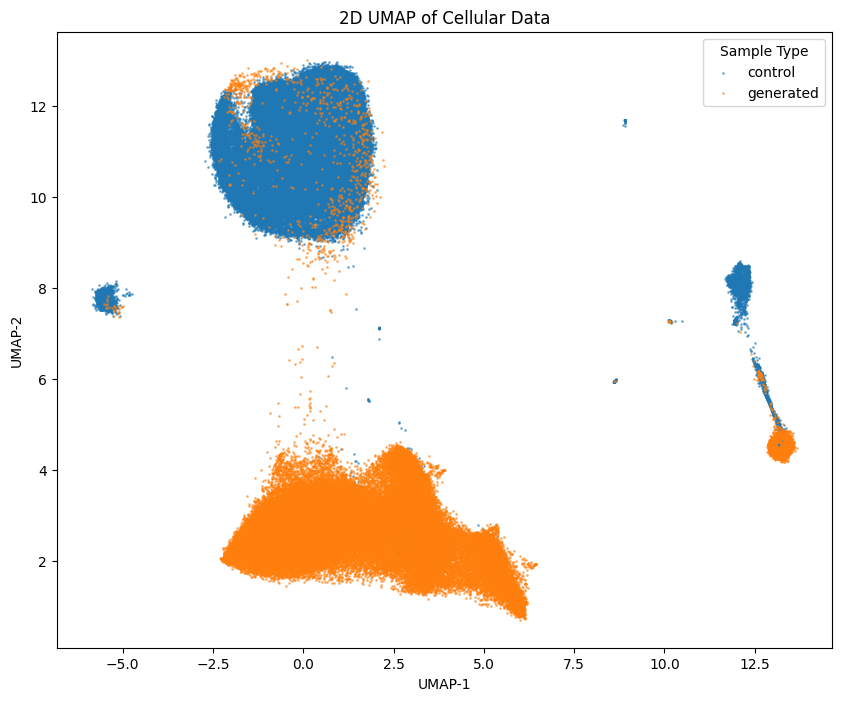

In [39]:
# Create a color/label array
# Assuming the number of samples in each array is ctr_expr.shape[0], gt_pert_np.shape[0], perturbed_cells_np.shape[0]
data = np.concatenate([adata_all_perts.X, all_perts], axis=0)

labels = np.concatenate([
    np.full(adata_all_perts.X.shape[0], 'control'),
    np.full(all_perts.shape[0], 'generated')
])

# UMAP reduction
reducer = umap.UMAP()
embedding = reducer.fit_transform(data)

# Plotting
plt.figure(figsize=(10, 8))
for label in np.unique(labels):
    idx = labels == label
    plt.scatter(embedding[idx, 0], embedding[idx, 1], label=label, alpha=0.5, s=1)

plt.title('2D UMAP of Cellular Data')
plt.xlabel('UMAP-1')
plt.ylabel('UMAP-2')
plt.legend(title='Sample Type')
plt.show()

In [28]:
data_dir = "/home/dfl32/project/ifm/data"
save_fn = "gen_cells.pickle"
save_path = os.path.join(data_dir, save_fn)

with open(save_path, "rb") as f:
    perturbed_cells_dict = pickle.load(f)

all_perts = [perturbed_cells_dict[key] for key in perturbed_cells_dict]
combo_labels = []
cell_type_labels = []
pert_labels = []
for key in perturbed_cells_dict:
    combo_labels += [key]*len(perturbed_cells_dict[key])
    cell_type_labels += [key[0]]*len(perturbed_cells_dict[key])
    pert_labels += [key[1]]*len(perturbed_cells_dict[key])
all_perts = np.concatenate(all_perts, axis=0)
ifm_adata = anndata.AnnData(X=all_perts)
ifm_adata.obs['cell_type'] = cell_type_labels
ifm_adata.obs['perturbation'] = pert_labels
ifm_adata.obs['sample'] = ['ifm']*len(ifm_adata)
simple_adata_all_perts = anndata.AnnData(X=adata_all_perts.X)
simple_adata_all_perts.obs['cell_type'] = list(adata_all_perts.obs['cell_type'])
simple_adata_all_perts.obs['perturbation'] = list(adata_all_perts.obs['perturbation'])
simple_adata_all_perts.obs['sample'] = ['train data']*len(simple_adata_all_perts)
combined_adata = anndata.concat([simple_adata_all_perts, ifm_adata])

/home/dfl32/.conda/envs/c2s2/lib/python3.11/site-packages/anndata/_core/anndata.py:1818: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


/home/dfl32/.conda/envs/c2s2/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:1234: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
/home/dfl32/.conda/envs/c2s2/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/home/dfl32/.conda/envs/c2s2/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:1234: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
/

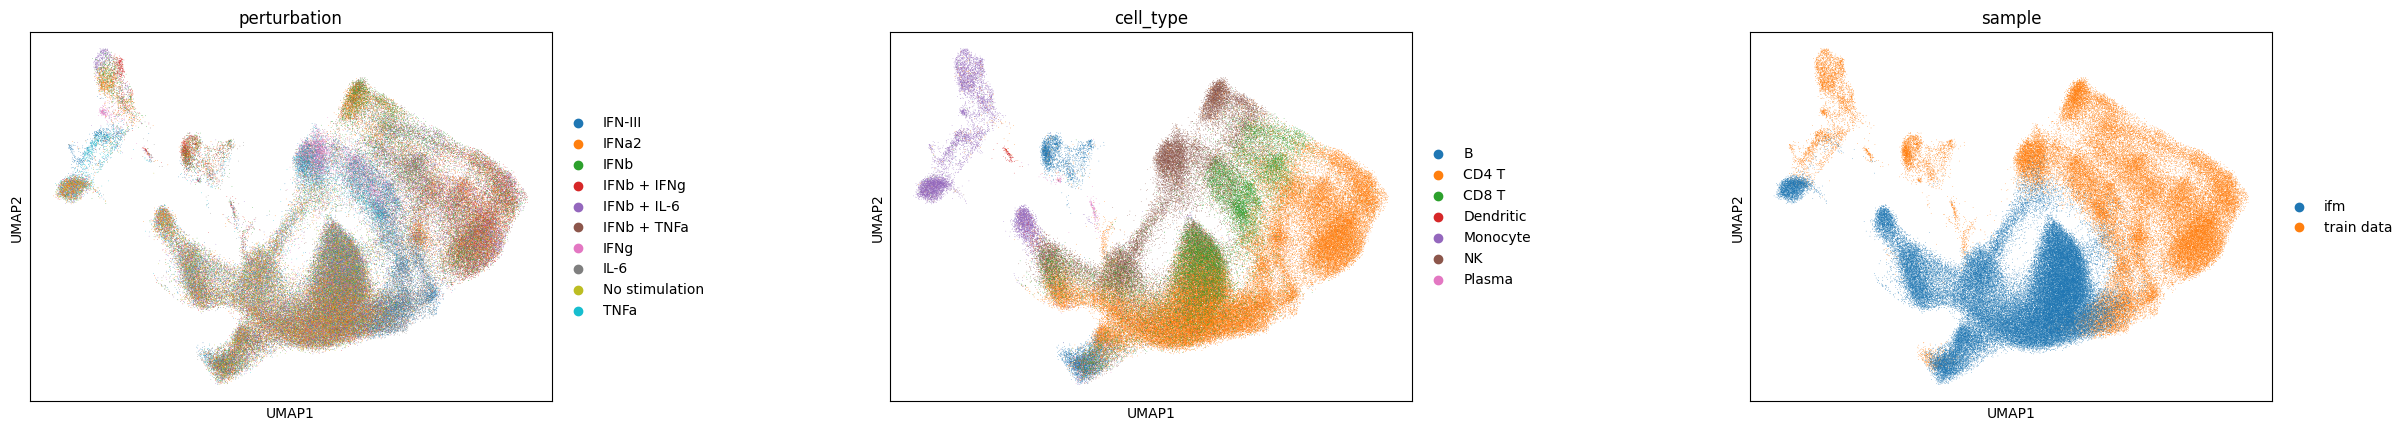

In [30]:
sc.pp.pca(combined_adata)
sc.pp.neighbors(combined_adata)
sc.tl.umap(combined_adata)
sc.pl.umap(combined_adata, color=['perturbation', 'cell_type', 'sample'], wspace=0.5)